### Predicting Tennis Players' Ranking ###

Tennis, a globally cherished sport, epitomizes elegance, precision, and athleticism. Played on various surfaces like grass, clay, and hard court, tennis involves players rallying a ball back and forth over a net using rackets. One crucial aspect of tennis is the occurrence of double faults and aces. A double fault happens when a player fails to get both serves in bounds, resulting in the loss of a point. Conversely, an ace occurs when a serve is untouched by the opponent, leading to an instant point for the server. In the realm of tennis analytics, understanding the frequency and impact of double faults and aces can offer valuable insights into player performance, strategy, and match outcomes. To explore this, we will analyze a comprehensive dataset comprising match statistics, including serve performance, from various professional tennis tournaments. This analysis aims to uncover patterns and correlations between double faults, aces, and match results, ultimately shedding light on the significance of serving proficiency and its relationship to player rank. We will also ask if a paticular tennis player's rank, can be predicted by the number of aces and double faults they make per game.

**---This should be fine as is, but we need 2000 words total AND two sources so maybe we could bulk this up a bit more. Might want to specify where the data comes from specifically or do that in next paragraph**

**--- NEED A LEGEND AND LABELS FOR ALL GRAPHS AND TABLES! Probably at start?**

**Preparing the Data**

After installing the relevant packages, we downloaded and read the dataset titled “Game results for Top 500 Players from 2017-2019” from the provided google drive.

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
# read the data 
# note: The code below will download the data into the current working directory and read it
url <- "https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn"
download.file(url, "./atp2017-2019.csv")
player_result <- read_csv("./atp2017-2019.csv")

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

We then limited the dates to the year 2019 by filtering and then selected the columns of interest which included, the player’s ID, aces, double faults, and the ranks for both winners and losers respectively. We then merged the corresponding winner and loser columns for each attribute, which resulted in a simplified data frame consisting of 4 columns: ID, ace, df(double faults), and rank. Therefore, each row in this frame represents a single observation. Any observations with missing values were also removed.

In [2]:
# filter year 2019, there is indeed a more formal way with more steps to do that,
# but we can simply do it this way with only one step because we don't need the
# year information later on
player_2019 <- filter(player_result, tourney_date <= 20199999
                       , tourney_date >=20190000) |>
  select(winner_id, loser_id, w_ace, l_ace, w_df, l_df, winner_rank, loser_rank)

# seperate the original data into winner and loser
player_winner <- player_2019 |>
  select(winner_id, w_ace, w_df, winner_rank) |>
  rename(id = winner_id, ace = w_ace, df = w_df, rank = winner_rank)
player_loser <- player_2019 |>
  select(loser_id, l_ace, l_df, loser_rank) |>
  rename(id = loser_id, ace = l_ace, df=l_df, rank = loser_rank)

# Combine them together by rows to form a data into a tidy format
player_clean <- bind_rows(player_winner, player_loser)|>
na.omit()
head(player_clean)

id,ace,df,rank
<dbl>,<dbl>,<dbl>,<dbl>
105815,7,2,63
111815,17,5,93
105815,9,0,63
111815,11,0,93
105526,22,3,58
105815,11,1,63


Finally, we split the data into training and testing sets, allocating a 0.75 proportion to the training set.

In [3]:
# Split data into training data and testing data
set.seed(8888)
player_split <- player_clean |>
  initial_split(prop = 0.75, strata = rank)
player_training <- training(player_split)
player_testing <- testing(player_split)
head(player_training)

id,ace,df,rank
<dbl>,<dbl>,<dbl>,<dbl>
126774,8,1,15
104925,6,2,1
105676,9,3,22
106421,7,4,19
105807,20,3,23
105453,6,3,9


**Exploring The Data**

After summarizing the training data, we found that the average number of aces was 6.504, and the average number of double faults was 3.030. In addition, we ensured that all the variables of interest did not contain any missing values since this could interfere with the analysis later.

In [4]:
# Exploratory data analysis to training data
Summarised_training <- player_training |>
  summarize(ace_mean = mean(ace, na.rm = TRUE),
            df_mean = mean(df, na.rm = TRUE),
            missing_id = sum(is.na(id)), 
            missing_ace = sum(is.na(ace)),
            missing_df = sum(is.na(df)),
            missing_rank = sum(is.na(rank)))
Summarised_training

ace_mean,df_mean,missing_id,missing_ace,missing_df,missing_rank
<dbl>,<dbl>,<int>,<int>,<int>,<int>
6.504112,3.029605,0,0,0,0


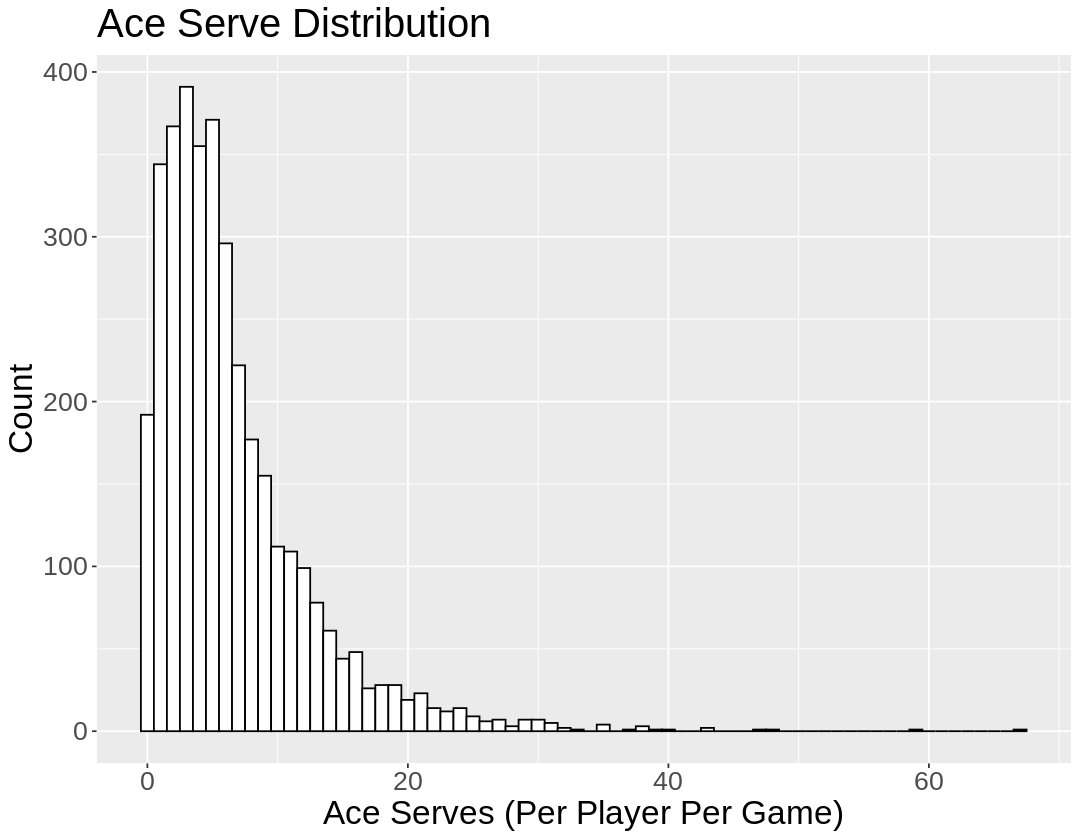

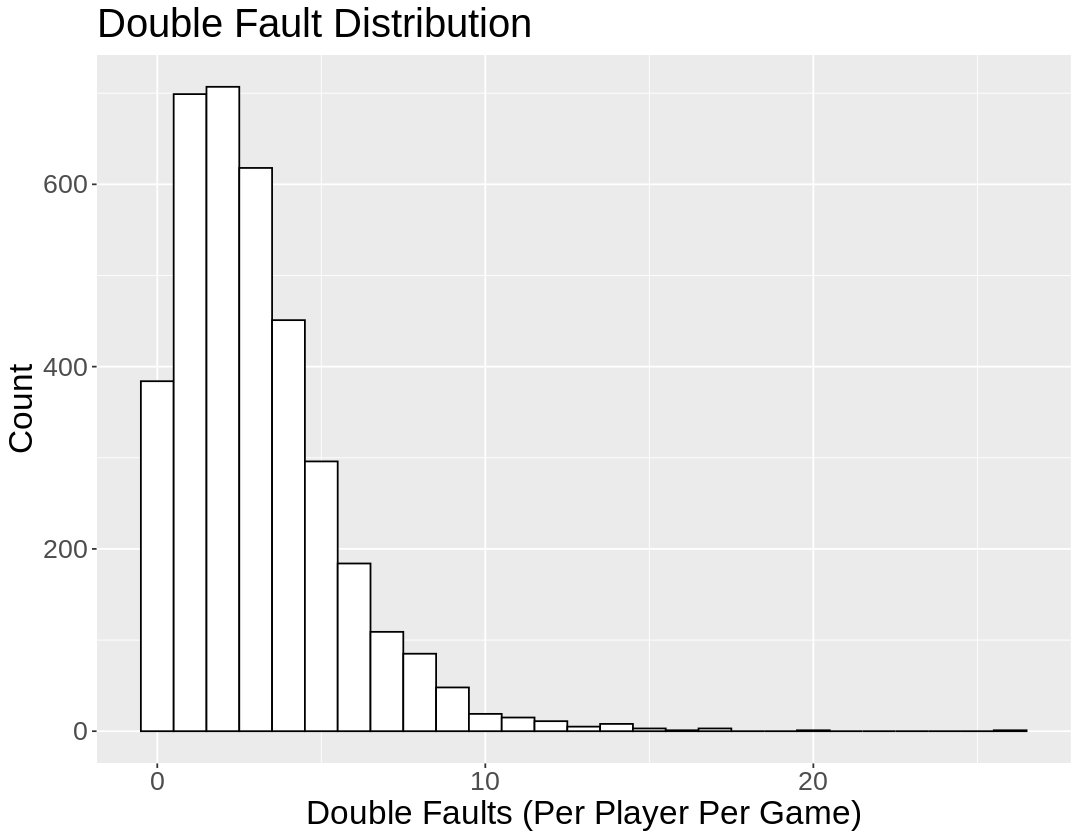

In [17]:
options(repr.plot.width = 9, repr.plot.height = 7) 

ace_plot<-ggplot(player_training, aes(x=ace))+
    geom_histogram(binwidth=1, colour="black", fill="white") +
    xlab("Ace Serves (Per Player Per Game)") +
    ylab("Count") +
    ggtitle("Ace Serve Distribution") +
    theme(text = element_text(size=20))

df_plot<-ggplot(player_training, aes(x=df))+
    geom_histogram(binwidth=1, colour="black", fill="white") +
    xlab("Double Faults (Per Player Per Game)") +
    ylab("Count") +
    ggtitle("Double Fault Distribution")+
    theme(text = element_text(size=20))
ace_plot
df_plot



**Performing the Analysis**

Now we can perform the regression analysis. We do not know the optimal K value, so we will have to detremine that during the analysis.Firstly, we must create the two components in our workflow which are the model and the recipe.
We have also created some cross-validation folds for our evaluation of K which will happen later.

In [6]:
set.seed(3636)
ace_spec<- nearest_neighbor(weight_func = "rectangular", neighbors =tune()) |> 
       set_engine("kknn") |>
       set_mode("regression") 

ace_recipe<- recipe(rank ~ ace , data =player_training) |>
       step_scale(all_predictors()) |>
       step_center(all_predictors())

ace_cv<-vfold_cv(player_training, v=5, strata = rank)

We have now created a work flow and have tested multiple values of K from 1 to 81. Looking at the lowest RMSE value, we have determined that the best K value is **FIGURE OUT LATER**.

In [14]:
set.seed(3636)
ace_workflow<-workflow()|>
add_recipe(ace_recipe)|>
add_model(ace_spec)

ace_gridvals<-tibble(neighbors=seq(from=1, to=81, by=10))

ace_results<-ace_workflow|>
tune_grid(resamples= ace_cv , grid=ace_gridvals)|>
collect_metrics()

ace_min<-ace_results |>
    filter(.metric == "rmse") |>
    slice_min(mean, n=1)
ace_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
81,rmse,standard,78.49805,5,2.025209,Preprocessor1_Model9


Now that we have a tuned K value, we are able to create an optimized model and workflow for our regression analysis.

In [8]:
ace_spec_tuned <- nearest_neighbor(weight_func ="rectangular", neighbors = FIGURE OUT LATER) |>
          set_engine("kknn") |>
          set_mode("regression")

ace_workflow_tuned <- workflow() |>
          add_recipe(ace_recipe) |>
          add_model(ace_spec_tuned) |>
          fit(data = player_training)

ERROR: Error in parse(text = x, srcfile = src): <text>:1:83: unexpected symbol
1: ace_spec_tuned <- nearest_neighbor(weight_func ="rectangular", neighbors = FIGURE OUT
                                                                                      ^


We will now see how accurate our regression model is by applying our testing data through it.**CANNOT WRITE THE RESULTS ATM BECAUSE I CANNOT SEE THEM. COULD ALSO PUT THIS IN DISCUSSION SECTION**

In [ ]:
ace_summary <- ace_workflow_tuned |>
           predict(player_testing) |>
           bind_cols(player_testing) |>
           metrics(truth = rank , estimate = .pred)

**Visualizing the Analysis**

**It's hard to write about the visual part without visualizing it so will put in once issue is resolved. Could also combine all data points for better looking graph (see notes in regression skeleton). The line represents what our model predicts the rank to be at a certain number of ace serves per game**

In [ ]:
options(repr.plot.width = 9, repr.plot.height = 7)

PLOT<-ggplot(DATA TO BE DECIDED UPON)+
geom_point(aes(y=rank, x=ace), alpha= IF WE NEED IT)+
geom_line(aes(y=.pred, x=ace), color="blue")+
xlab("Number of Ace Serves (per player per game)")+
ylab("Ranking of Player")+
ggtitle("Predicting Player Rank Based on Number of Ace Serves They Acheive")

**Discussion**

**---summarize what we found and 
discuss whether this is whatweu expected to find. Also might want to expand upon section below**?

The outcome of this data will allow players to get a sense of where they rank based on how many ace serves and double faults they have done throughout a game. Furthermore, some questions this project could lead to is: “What other factors are there to determine where a player ranks?”,  “Can we estimate a player's ranking based on the ratio of double fault to ace serve?”, and “Will the type of serve be important in the tournament as a whole?

**Bibliography**
**---Need another ref and can put where we got our data from here**

What is an Ace and Double fault in Tennis. (2010, July 1). Something about Everything. https://whyentrepreneurs.wordpress.com/2010/07/01/what-is-an-ace-and-double-fault-in-tennis/